In [16]:
import requests, zlib, io
import numpy as np
import pandas as pd
import multiprocessing
from urllib.parse import quote

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
url = 'http://localhost:8080'
data_type = ('sentences', 'paragraphs')[1]
model = 'en_w2v'

### Create dataset

In [40]:
def uncompress_numpy_array(bytestring):
    return np.load(io.BytesIO(zlib.decompress(bytestring)))

def encode(idx_text_tuple):
    idx, text = idx_text_tuple
    api_result = requests.get(f'{url}/{quote(text)}/{model}')
    return {'index': idx, 'feats': uncompress_numpy_array(api_result.content)}

In [41]:
# read data and extract features
data = (
    pd.read_pickle(data_type)
    .assign(undude = lambda df: df['character']!='DUDE')
    .assign(num_words = lambda df: df['text'].apply(lambda s: len(s.split())))
)

# use multiprocessing for efficiency
idx_text_tuples = [(idx, text) for idx, text in zip(data.index, data['text'])]
# with multiprocessing.Pool(4) as enc_pool:
#     encs = enc_pool.map(encode, idx_text_tuples)
encs = [encode(idx_text_tuple) for idx_text_tuple in idx_text_tuples]

# join data together
data = data.join(pd.DataFrame(encs).set_index('index'))

In [43]:
print(data.shape)
data.sample(3)

(912, 5)


,character,text,undude,num_words,feats
861,DIETER,I haff lingenberry pancakes.,True,4,"[0.14389579, 0.1677846, -0.05914401, -0.267779..."
563,WALTER,"Hello, Pilar? My name is Walter Sobchak, we s...",True,18,"[-0.03044079, 0.23585914, -0.1451014, -0.01326..."
801,MAUDE,Sex. The physical act of love. Coitus. Do yo...,True,11,"[-0.026457936, 0.13985118, -0.14896223, -0.148..."


### Decode: classify names

In [45]:
# concatenate features
X = np.zeros((len(data), len(data['feats'].iloc[0])))
for i in range(len(X)):
    X[i,:] = data['feats'].iloc[i]

# use one-hot-enc as labels
one_hot = OneHotEncoder().fit(data['character'].values.reshape(-1,+1))
Y = one_hot.transform(data['character'].values.reshape(-1,+1)).todense()

In [46]:
model = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000)
accuracies = []
confmat = None

splits = StratifiedShuffleSplit(n_splits=5)
for train_idx, test_idx in splits.split(X, Y):

    model.fit(X[train_idx], Y[train_idx])
    P = model.predict(X[test_idx])
    T = Y[test_idx]
    accuracies.append(accuracy_score(T, P))
    print(accuracies[-1])

    cm = confusion_matrix(T.argmax(axis=1), P.argmax(axis=1))
    confmat = cm if confmat is None else cm+confmat


0.4673913043478261
0.3695652173913043
0.391304347826087
0.4891304347826087
0.41304347826086957


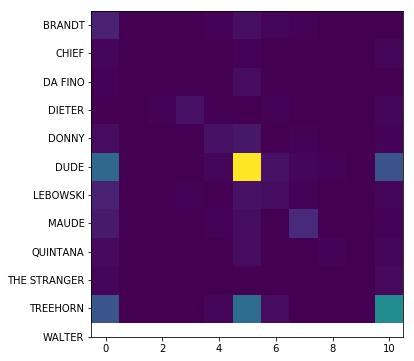

In [25]:
plt.rcParams['figure.figsize'] = 6,6
plt.imshow(confmat);
plt.yticks(range(len(one_hot.categories_[0])), one_hot.categories_[0]);

In [47]:
data['character'].value_counts()/len(data)

DUDE            0.445175
WALTER          0.282895
MAUDE           0.066886
LEBOWSKI        0.048246
BRANDT          0.044956
DONNY           0.044956
THE STRANGER    0.019737
TREEHORN        0.012061
DIETER          0.010965
DA FINO         0.009868
CHIEF           0.007675
QUINTANA        0.006579
Name: character, dtype: float64

> You's be better off just always predicting 'DUDE'

### Dude / UnDude

In [48]:
model = SVC(gamma='scale')
accuracies = []
single_confmat = None

splits = StratifiedShuffleSplit(n_splits=5)
for train_idx, test_idx in splits.split(X, Y):

    model.fit(X[train_idx], data['undude'][train_idx])
    P = model.predict(X[test_idx])
    T = data['undude'][test_idx]
    accuracies.append(accuracy_score(T, P))

    cm = confusion_matrix(T, P)
    single_confmat = cm if single_confmat is None else cm+single_confmat

print(np.mean(accuracies))
print(single_confmat)

0.6326086956521738
[[ 85 120]
 [ 49 206]]
